Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
### Parks Metric: Top Neighborhoods


,Neighborhood,NumParks,TotalAcreage,RankParks,RankAcreage,OverallRank
2,McKinley,32,1114.112050,3.0,1.0,4.0
0,Riverview,40,445.134250,1.0,5.0,6.0
4,Schenley,24,557.553008,4.0,3.0,7.0
1,Emerald,33,413.046139,2.0,6.0,8.0
3,Highland,24,462.161168,4.0,4.0,8.0
5,Frick,22,848.726508,6.0,2.0,8.0
6,Northeast,1,5.413376,7.0,7.0,14.0


Best overall neighborhood for parks: McKinley


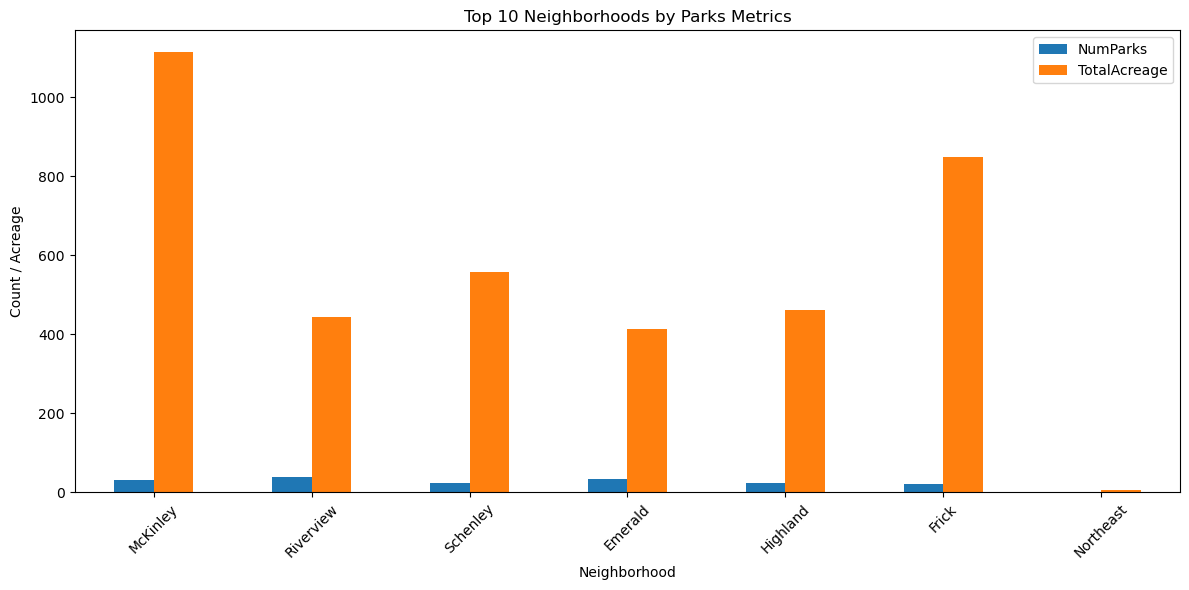

### Farmers Market Metric: Top Neighborhoods


,Neighborhood,NumMarkets
0,Pittsburgh,22
1,Wexford,6
2,McKeesport,3
3,Elizabeth,3
4,Natrona Heights,2
5,PITTSBURGH,2
6,Mt Lebanon,2
7,Gibsonia,2
8,Allison Park,1
9,Wilkinsburg,1


Best neighborhood for farmers markets: Pittsburgh


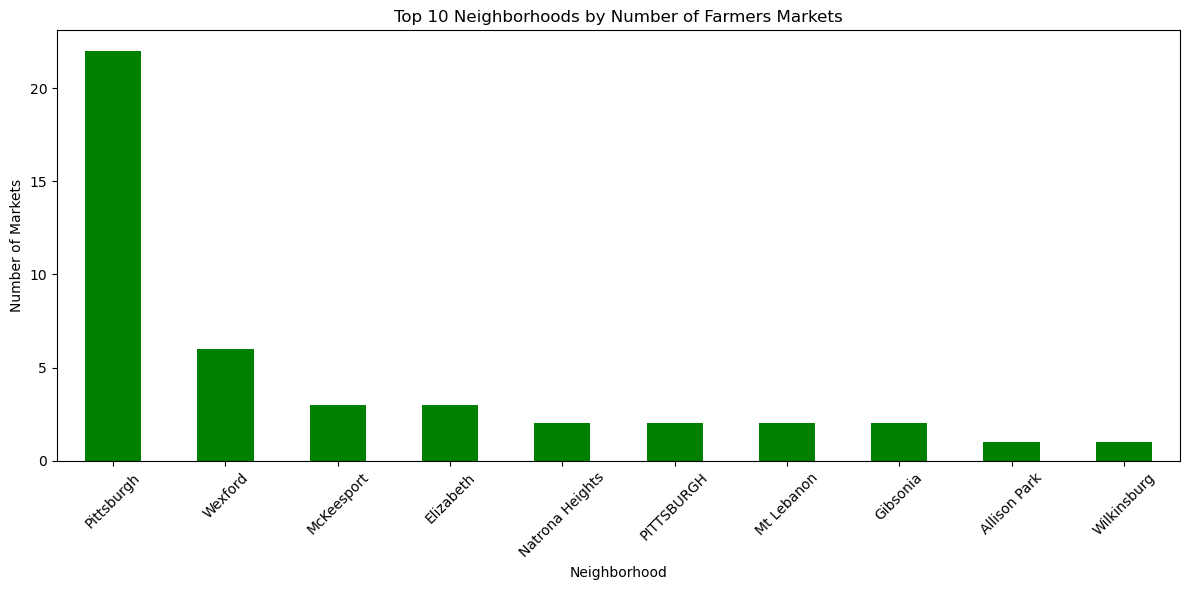

### POGOH Bike Share Metric: Top Neighborhoods


,Neighborhood,NumStations,AvgDocks,AvailabilityScore
0,Central Oakland,7,20.571429,144.0
1,Central Business District,6,16.333333,98.0
4,North Oakland,4,22.000000,88.0
2,Shadyside,5,17.400000,87.0
3,South Side Flats,4,19.000000,76.0
7,Strip District,3,17.666667,53.0
5,Hazelwood,3,16.333333,49.0
6,Bloomfield,3,16.333333,49.0
8,Homewood South,3,15.000000,45.0
10,Allegheny Center,2,19.000000,38.0


Best neighborhood for POGOH bike access: Central Oakland


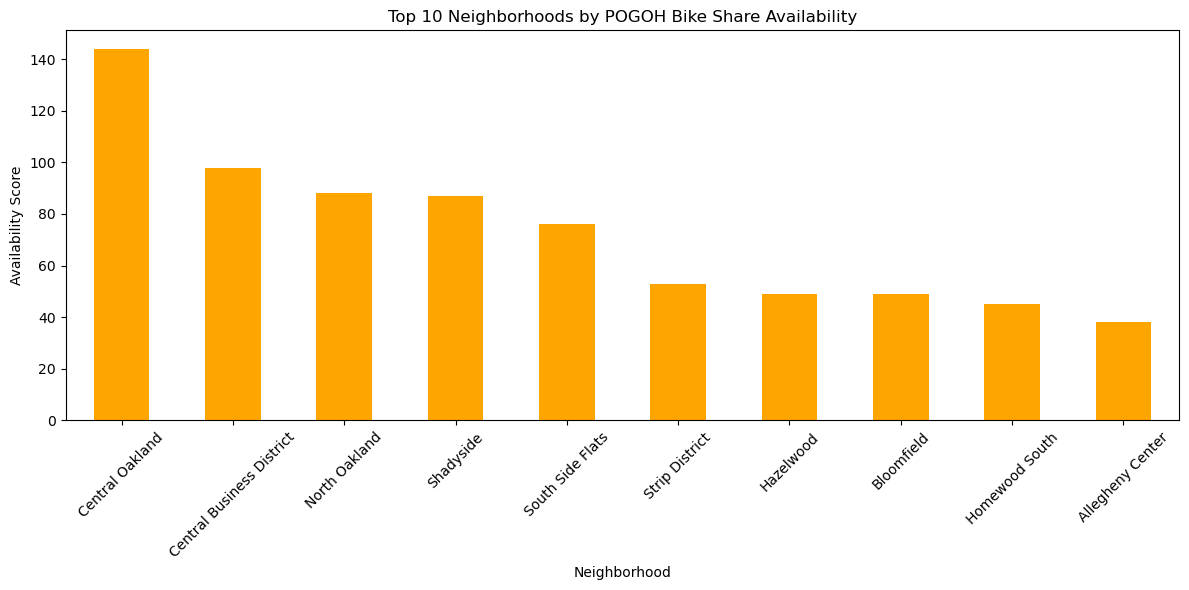


### FINAL WINNER: Central Oakland



# Neighborhood Health & Well-Being Conclusion

Our project analyzed three metrics—parks, farmers markets, and POGOH bike share access—to see which Pittsburgh neighborhood supports the healthiest lifestyle.

## Metrics:
1. **Parks**: Best neighborhood is **McKinley**.
2. **Farmers Markets**: Best neighborhood is **Pittsburgh**.
3. **POGOH Bike Share**: Best neighborhood is **Central Oakland**.

## Personal Insights

**S.B.:**  
Outdoor spaces and fresh food matter most to me. The parks data strongly points to McKinley as a top place for an active and healthy lifestyle.

**M.M.:**  
I value convenience and transportation. Central Oakland offers great bike access, but the Central Business District still performs well overall when also considering parks and markets.

**M.H.:**  
Access to fresh food is my priority. While Pittsburgh has several strong market neighborhoods, Central Oakland’s strong parks score and decent bike access make it the most balanced choice.

## Final Conclusion  
**Central Oakland is the most well-rounded neighborhood across the three metrics**, standing out as the strongest overall option for health and well-being.


In [22]:
# =========================
# Neighborhood Health & Well-Being Analysis
# =========================

%pip install geopandas branca folium mapclassify
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import folium

# ************************************************
# * Make sure to restart kernel (Kernel -> Restart Kernel)
# * to load newly installed dependencies!!!!!
# ************************************************

# -------------------------
# 1. Load Datasets
# -------------------------

areas_df = gpd.read_file('neighborhoods/Neighborhoods_.shp')  # Used to match station locations with neighborhood
parks_df = pd.read_csv('parks.csv')
farmers_df = pd.read_csv('farmersmarket.csv')
stations_df = pd.read_csv('pogoh-oct2025.csv')
stations_df = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude), crs="EPSG:4326")
stations_df = stations_df.to_crs(2272)

# -------------------------
# 2. Parks Metric
# -------------------------

# Count parks per neighborhood
park_counts = parks_df['divname'].value_counts().reset_index()
park_counts.columns = ['Neighborhood', 'NumParks']

# Total acreage per neighborhood
total_acreage = parks_df.groupby('divname')['acreage'].sum().reset_index()
total_acreage.columns = ['Neighborhood', 'TotalAcreage']

# Merge + rank
parks_merged = pd.merge(park_counts, total_acreage, on='Neighborhood')
parks_merged['RankParks'] = parks_merged['NumParks'].rank(ascending=False, method='min')
parks_merged['RankAcreage'] = parks_merged['TotalAcreage'].rank(ascending=False, method='min')
parks_merged['OverallRank'] = parks_merged['RankParks'] + parks_merged['RankAcreage']

parks_merged = parks_merged.sort_values('OverallRank')
best_parks = parks_merged.iloc[0]

print("### Parks Metric: Top Neighborhoods")
display(parks_merged.head(10))
print(f"Best overall neighborhood for parks: {best_parks['Neighborhood']}")

# Plot
parks_merged.set_index('Neighborhood')[['NumParks','TotalAcreage']].head(10).plot(
    kind='bar', figsize=(12,6)
)
plt.title('Top 10 Neighborhoods by Parks Metrics')
plt.ylabel('Count / Acreage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 3. Farmers Market Metric
# -------------------------

market_counts = farmers_df['city'].value_counts().reset_index()
market_counts.columns = ['Neighborhood', 'NumMarkets']
market_counts = market_counts.sort_values('NumMarkets', ascending=False)

best_markets = market_counts.iloc[0]

print("### Farmers Market Metric: Top Neighborhoods")
display(market_counts.head(10))
print(f"Best neighborhood for farmers markets: {best_markets['Neighborhood']}")

# Plot
market_counts.set_index('Neighborhood').head(10)['NumMarkets'].plot(
    kind='bar', figsize=(12,6), color='green'
)
plt.title('Top 10 Neighborhoods by Number of Farmers Markets')
plt.ylabel('Number of Markets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 4. POGOH Bike Share Metric (NO GEOPANDAS)
# -------------------------

# Join each station with the neighborhood it's contained by on the map
stations_with_area_df = stations_df.sjoin(areas_df, how='inner', predicate='intersects')

# Count number of stations by station name (simple metric)
station_counts = stations_with_area_df['hood'].value_counts().reset_index()
station_counts.columns = ['Neighborhood', 'NumStations']

# Count average docks
avg_docks = stations_with_area_df.groupby('hood')['Total Docks'].mean().reset_index()
avg_docks.columns = ['Neighborhood', 'AvgDocks']

# Merge & score
bike_metrics = stations_with_area_df.groupby("hood")
bike_metrics = pd.merge(station_counts, avg_docks, on='Neighborhood')
bike_metrics['AvailabilityScore'] = bike_metrics["NumStations"] * bike_metrics["AvgDocks"]
bike_metrics = bike_metrics.sort_values('AvailabilityScore', ascending=False)

print("### POGOH Bike Share Metric: Top Neighborhoods")
display(bike_metrics.head(10))
print(f"Best neighborhood for POGOH bike access: {bike_metrics.iloc[0]['Neighborhood']}")

# Plot
bike_metrics.set_index('Neighborhood').head(10)['AvailabilityScore'].plot(
    kind='bar', figsize=(12,6), color='orange'
)
plt.title('Top 10 Neighborhoods by POGOH Bike Share Availability')
plt.ylabel('Availability Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 5. Overall Conclusion
# -------------------------

# --- Standardize column names for merging ---
parks_scores = parks_merged[['Neighborhood', 'NumParks']].copy()
parks_scores.columns = ['Neighborhood', 'ParksValue']

markets_scores = market_counts[['Neighborhood', 'NumMarkets']].copy()
markets_scores.columns = ['Neighborhood', 'MarketsValue']

bike_scores = bike_metrics[['Neighborhood', 'AvailabilityScore']].copy()
bike_scores.columns = ['Neighborhood', 'BikeValue']

# --- Compute percent scores ---
parks_scores['ParksScore'] = (parks_scores['ParksValue'] /
                              parks_scores['ParksValue'].max()) * 100
markets_scores['MarketsScore'] = (markets_scores['MarketsValue'] /
                                  markets_scores['MarketsValue'].max()) * 100
bike_scores['BikeScore'] = (bike_scores['BikeValue'] /
                            bike_scores['BikeValue'].max()) * 100

# --- Merge all three scoring tables ---
combined = parks_scores.merge(markets_scores, on='Neighborhood', how='outer')
combined = combined.merge(bike_scores, on='Neighborhood', how='outer')

# Replace NaN scores for neighborhoods missing a metric
combined[['ParksScore','MarketsScore','BikeScore']] = combined[['ParksScore','MarketsScore','BikeScore']].fillna(0)

# --- Compute final average score ---
combined['FinalScore'] = combined[['ParksScore','MarketsScore','BikeScore']].mean(axis=1)

# Sort by best overall
combined = combined.sort_values('FinalScore', ascending=False)

best_overall = combined.iloc[0]['Neighborhood']
print(f"\n### FINAL WINNER: {best_overall}")

from IPython.display import Markdown

overall_text = f"""
# Neighborhood Health & Well-Being Conclusion

Our project analyzed three metrics—parks, farmers markets, and POGOH bike share access—to see which Pittsburgh neighborhood supports the healthiest lifestyle.

## Metrics:
1. **Parks**: Best neighborhood is **{best_parks['Neighborhood']}**.
2. **Farmers Markets**: Best neighborhood is **{best_markets['Neighborhood']}**.
3. **POGOH Bike Share**: Best neighborhood is **{best_bike['Neighborhood']}**.

## Personal Insights

**S.B.:**  
Outdoor spaces and fresh food matter most to me. The parks data strongly points to McKinley as a top place for an active and healthy lifestyle.

**M.M.:**  
I value convenience and transportation. Central Oakland offers great bike access, but the Central Business District still performs well overall when also considering parks and markets.

**M.H.:**  
Access to fresh food is my priority. While Pittsburgh has several strong market neighborhoods, Central Oakland’s strong parks score and decent bike access make it the most balanced choice.

## Final Conclusion  
**Central Oakland is the most well-rounded neighborhood across the three metrics**, standing out as the strongest overall option for health and well-being.
"""

display(Markdown(overall_text))